In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import pickle

Carregando os dados

In [2]:
list_data = []

for n in range(1, 59):
  list_data.append(json.load(open(r"C:\Users\natha\Documents\activities\({}).json".format(n),"rb")))

In [3]:
df = pd.DataFrame()

for x in range(0,58):
  teste = list_data[x]
  teste = pd.json_normalize(teste)[["summaries", "tags.com.nike.name"]]

  prov = pd.json_normalize(teste.summaries[0])
  prov['metric_all'] = prov.metric+'_'+prov.summary

  final = prov[['metric_all', 'value']].T
  final = final.reset_index(drop=True)
  final.columns = final.iloc[0]
  final = final.tail(1).reset_index(drop=True)

  final['dia'] = teste["tags.com.nike.name"]

  df = df.append(final).reset_index(drop=True)

Clustering

In [4]:
columns_data = ['speed_mean', 'distance_total', 'calories_total', 'pace_mean']

df = df[columns_data].copy()

In [5]:
df.speed_mean = round(df.speed_mean.astype(float),2)
df.distance_total = round(df.distance_total.astype(float),2)
df.calories_total = round(df.calories_total.astype(float),2)
df.pace_mean = round(df.pace_mean.astype(float),2)

In [6]:
#transformando pace
df['pace_real'] = df.pace_mean.apply(int) + (round(((df.pace_mean - 
                                                     df.pace_mean.apply(int)) * 60),0) / 100)

In [7]:
df.head()

,speed_mean,distance_total,calories_total,pace_mean,pace_real
0,9.31,5.01,277.36,6.45,6.27
1,9.51,5.01,278.40,6.31,6.19
2,9.40,5.03,279.34,6.38,6.23
3,9.56,5.01,279.45,6.28,6.17
4,9.39,5.01,278.26,6.39,6.23


In [8]:
#algumas estatísticas descritivas
print('Total corridas:', len(df), 'corridas')
print('Km corridos:', round(df.distance_total.sum(),2))
print('Pace médio (todas as corridas):', round(df.pace_real.mean(),2))
print('Distância média (todas as corridas):', round(df.distance_total.mean(),2))
print('Total calorias:', round(df.calories_total.sum(),2))

Total corridas: 58 corridas
Km corridos: 321.83
Pace médio (todas as corridas): 6.19
Distância média (todas as corridas): 5.55
Total calorias: 17917.81


In [9]:
columns_keep = ['speed_mean','distance_total','pace_real','calories_total']

df_X = df[columns_keep].copy()

In [10]:
#padronização
scaler = StandardScaler()

to_transform_data = df_X.copy()
to_transform_cols = to_transform_data.columns

transformed = scaler.fit_transform(to_transform_data)
df_X.loc[:, to_transform_cols] = transformed

In [11]:
#definição de x
X = df_X.values

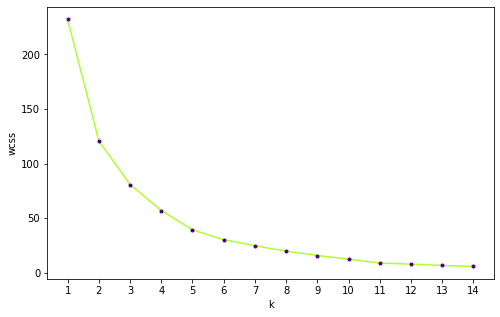

In [12]:
#encontrando n de clusters
wcss = []
n_cluster = range(1, 15)

for k in n_cluster:
    km = KMeans(n_clusters=k, n_init=30, random_state=1)
    km.fit(X)
    wcss.append(km.inertia_)

fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(n_cluster, wcss, color = 'greenyellow')
ax.plot(n_cluster, wcss, '.', color = 'indigo')
plt.xticks(n_cluster)
plt.xlabel("k")
plt.ylabel("wcss")

plt.show()

In [13]:
#documentação: O joelho/cotovelo é definido como o ponto da linha onde a curvatura é máxima
knl = KneeLocator(n_cluster, wcss, curve="convex", direction="decreasing")

knl.elbow

5

In [14]:
km = KMeans(n_clusters=5, n_init=30, random_state=1)
km.fit(X)

KMeans(n_clusters=5, n_init=30, random_state=1)

In [15]:
df_final = df_X.copy()
df_final['cluster'] = km.labels_

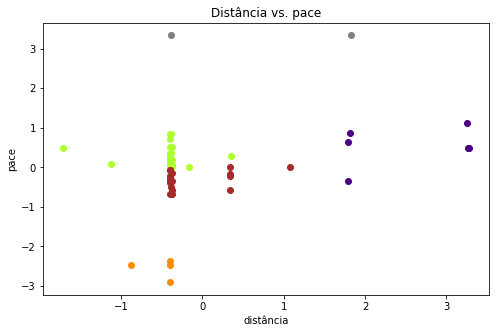

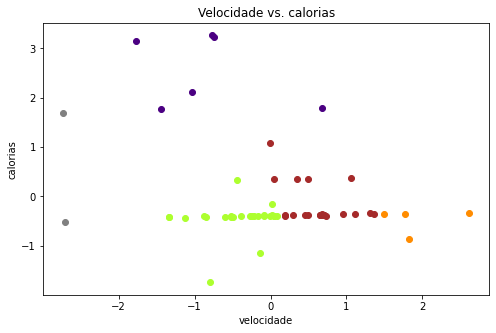

In [16]:
tags_clusters = df_final.cluster.unique()
tags_clusters.sort()
colors = ['greenyellow','indigo','darkorange','brown','gray']

#plot dos dados segmentados por cluster (distância vs. pace)
plt.subplots(figsize=(8, 5))
for n in tags_clusters:
    plt.scatter(df_final.loc[df_final.cluster == n].distance_total, df_final.loc[df_final.cluster == n].pace_real, color=colors[n], marker='o')
plt.title("Distância vs. pace")
plt.xlabel("distância")
plt.ylabel("pace")

#plot dos dados segmentados por cluster (velocidade vs. calorias)
plt.subplots(figsize=(8, 5))
for n in tags_clusters:
    plt.scatter(df_final.loc[df_final.cluster == n].speed_mean, df_final.loc[df_final.cluster == n].calories_total, color=colors[n], marker='o')
plt.title("Velocidade vs. calorias")
plt.xlabel("velocidade")
plt.ylabel("calorias")

plt.show()

In [17]:
silhouette_score(X, km.labels_).round(2)

0.43

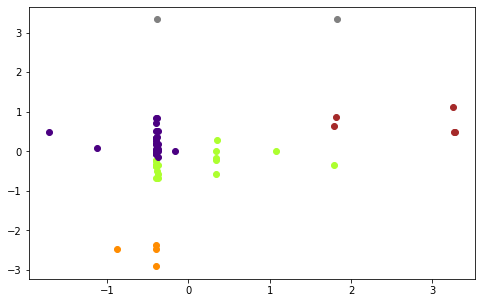

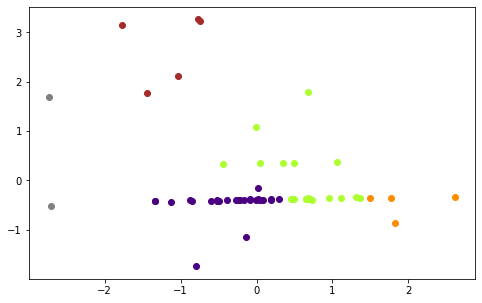

In [18]:
#treinando e plotando o agglomerative clustering
agl = AgglomerativeClustering(n_clusters=5)
pred = agl.fit_predict(X)
clusters = np.unique(pred)

colors = ['greenyellow','indigo','darkorange','brown','gray']

plt.subplots(figsize=(8, 5))
for c in clusters:
	row_true = np.where(pred == c)
	plt.scatter(X[row_true, 1], X[row_true, 2], color=colors[c], marker='o')
plt.show()

plt.subplots(figsize=(8, 5))
for c in clusters:
	row_true = np.where(pred == c)
	plt.scatter(X[row_true, 0], X[row_true, 3], color=colors[c], marker='o')  
plt.show()

In [19]:
silhouette_score(X, pred).round(2)

0.43

Interpretando clusters

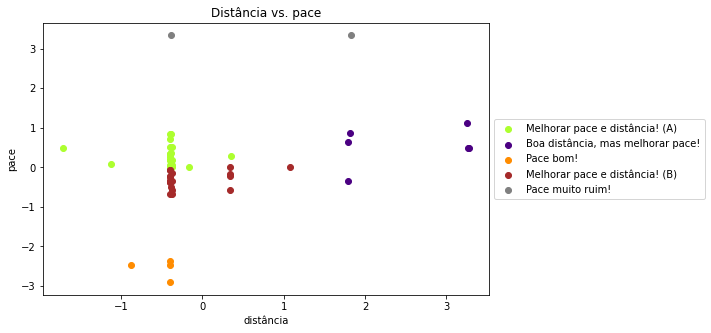

In [20]:
legend_dict = {
                0: 'Melhorar pace e distância! (A)',
                1: 'Boa distância, mas melhorar pace!',
                2: 'Pace bom!',
                3: 'Melhorar pace e distância! (B)',
                4: 'Pace muito ruim!'
                }

tags_clusters = list(legend_dict.keys())
colors = ['greenyellow','indigo','darkorange','brown','gray']

#plot dos dados segmentados por cluster com legenda (distância vs. pace)
plt.subplots(figsize=(8, 5))
for c in tags_clusters:
    plt.scatter(df_final.loc[df_final.cluster == c].distance_total, 
                df_final.loc[df_final.cluster == c].pace_real, 
                color=colors[c], marker='o', label = legend_dict[c])
plt.title("Distância vs. pace")
plt.xlabel("distância")
plt.ylabel("pace")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
df_final['legenda'] = np.nan
tags_clusters = list(legend_dict.keys())

for c in tags_clusters:
    df_final.loc[df_final.cluster == c, 'legenda'] = legend_dict[c]

In [22]:
df_final.head()

,speed_mean,distance_total,pace_real,calories_total,cluster,legenda
0,-0.493978,-0.392701,0.330564,-0.416095,0,Melhorar pace e distância! (A)
1,0.051231,-0.392701,0.018178,-0.402387,0,Melhorar pace e distância! (A)
2,-0.248634,-0.378124,0.174371,-0.389997,0,Melhorar pace e distância! (A)
3,0.187533,-0.392701,-0.059919,-0.388547,3,Melhorar pace e distância! (B)
4,-0.275894,-0.392701,0.174371,-0.404232,0,Melhorar pace e distância! (A)


In [23]:
df_final.legenda.value_counts()

Melhorar pace e distância! (A)       25
Melhorar pace e distância! (B)       21
Boa distância, mas melhorar pace!     6
Pace bom!                             4
Pace muito ruim!                      2
Name: legenda, dtype: int64

Salvando modelo, scaler e tags

In [24]:
pickle.dump(km, open("model.pickle", "wb"))
pickle.dump(scaler, open("scaler.pickle", "wb" ))
pickle.dump(legend_dict, open("legend_dict.pickle", "wb"))